In [41]:
import numpy as np
import tensorflow as tf


DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)




In [42]:
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, Activation, Concatenate, Multiply, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

LR_SIZE = 24
HR_SIZE = 96
upscaling_factor = 4
channels = 3
filters = 64

def SubpixelConv2D(name, scale=2):
        
        def subpixel_shape(input_shape):
            dims = [input_shape[0],
                    None if input_shape[1] is None else input_shape[1] * scale,
                    None if input_shape[2] is None else input_shape[2] * scale,
                    int(input_shape[3] / (scale ** 2))]
            output_shape = tuple(dims)
            return output_shape

        def subpixel(x):
            return tf.nn.depth_to_space(x, scale)

        return Lambda(subpixel, output_shape=subpixel_shape, name=name)

def upsample(x, number):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='upSampleConv2d_' + str(number))(x)
    x = SubpixelConv2D(name = str('upSampleSubPixel_') + str(number) , scale = 2)(x)
    x = PReLU(shared_axes=[1, 2], name='upSamplePReLU_' + str(number))(x)
    return x

def dense_block(input):
            
  x1 = Conv2D(64, kernel_size=3, strides=1, padding='same')(input)
  x1 = LeakyReLU(0.2)(x1)
  x1 = Concatenate()([input, x1])

  x2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(x1)
  x2 = LeakyReLU(0.2)(x2)
  x2 = Concatenate()([input, x1, x2])

  x3 = Conv2D(64, kernel_size=3, strides=1, padding='same')(x2)
  x3 = LeakyReLU(0.2)(x3)
  x3 = Concatenate()([input, x1, x2, x3])

  x4 = Conv2D(64, kernel_size=3, strides=1, padding='same')(x3)
  x4 = LeakyReLU(0.2)(x4)
  x4 = Concatenate()([input, x1, x2, x3, x4])  

  x5 = Conv2D(64, kernel_size=3, strides=1, padding='same')(x4)
  x5 = Lambda(lambda x: x * 0.2)(x5)
  x = Add()([x5, input])
  return x

def RRDB(input):
    x = dense_block(input)
    x = dense_block(x)
    x = dense_block(x)
    x = Lambda(lambda x: x * 0.2)(x)
    out = Add()([x, input])
    return out


def sr_resnet(num_filters=64, num_res_blocks=16):
    lr_input = Input(shape=(24, 24, 3))

    x_start = Conv2D(64, kernel_size=3, strides=1, padding='same')(lr_input)
    x_start = LeakyReLU(0.2)(x_start)

    x = RRDB(x_start)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x, x_start])

    x = upsample(x, 1)
    if upscaling_factor > 2:
            x = upsample(x, 2)
    if upscaling_factor > 4:
            x = upsample(x, 3)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    hr_output = Conv2D(channels, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
    
    
    model = Model(inputs=lr_input, outputs=hr_output)
  
    return model


generator = sr_resnet


def conv2d_block(input, filters, strides=1, bn=True):
      
      d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
                d = BatchNormalization(momentum=0.8)(d)
      return d



def discriminator(num_filters=64):
        img = Input(shape=(HR_SIZE,HR_SIZE,3))
        x = conv2d_block(img, filters, bn=False)
        x = conv2d_block(x, filters, strides=2)
        x = conv2d_block(x, filters * 2)
        x = conv2d_block(x, filters * 2, strides=2)
        x = conv2d_block(x, filters * 4)
        x = conv2d_block(x, filters * 4, strides=2)
        x = conv2d_block(x, filters * 8)
        x = conv2d_block(x, filters * 8, strides=2)
        x = Dense(filters * 16)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
        x = Dense(1)(x)

        # Create model and compile
        model = Model(inputs=img, outputs=x)
        return model

In [43]:
import os

tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


INFO:tensorflow:Initializing the TPU system: grpc://10.70.1.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.1.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [44]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  generator().summary()
  discriminator().summary()
  model = tf.keras.models.Sequential()
  model.add(generator())
  model.add(discriminator())
  model.summary()
  discriminator().compile(loss="binary_crossentropy", optimizer="rmsprop")
  discriminator().trainable = False
  model.compile(loss="binary_crossentropy", optimizer="rmsprop")

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 24, 24, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   36928       leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [ ]:
from tqdm import tqdm
import cv2

batch_size = 32

def train_dcgan(model,epochs=5):
   

    print("done")
    generator, discriminator = model.layers
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    discriminator.trainable = False
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    path = '/content/drive/MyDrive/cars_train/'
    for epoch in tqdm(range(epochs)):
      print("Epoch {}/{}".format(epoch + 1, epochs))
      for root, dirnames, filenames in os.walk(path):
        i = 0
        j = 0
        x_train_x = np.zeros((32,24,24,3))
        x_train_y = np.zeros((32,96,96,3))
        for filename in filenames:
          img_path = os.path.join(path,filename)
          x_train = cv2.imread(img_path)
          x_trainx = cv2.resize(x_train,(24,24))
          x_trainy = cv2.resize(x_train,(96,96))
          x_train_x[i] = x_trainx 
          x_train_y[i] = x_trainy
          i = i+1
          if i == 32:
            j = j + 1
            print("batch {}/254".format(j))
            X_batch, Y_batch = x_train_x, x_train_y
            X_batch = tf.cast(X_batch, tf.float32)
            Y_batch = tf.cast(Y_batch, tf.float32)
            generated_images = generator(X_batch)
            X = tf.cast(generated_images, tf.float32) 
            X_fake_and_real = tf.concat([X, Y_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            history_disc = discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            history_gen = model.train_on_batch(X_batch, y2)
            i = 0
            x_train_x = np.zeros((32,24,24,3))
            x_train_y = np.zeros((32,96,96,3))
    
      if (epoch+1)%10 == 0:

        generator.save_weights("Generator{}.h5".format(epoch))
        discriminator.save_weights("Discriminator_weights{}.h5".format(epoch))
        model.save_weights("Model{}.h5".format(epoch))
        from google.colab.patches import cv2_imshow

        path = "/content/drive/MyDrive/cars_train/07336.jpg"

        X = cv2.imread(path)
        X = cv2.resize(X,(24,24))
        X = np.reshape(X, (1,24,24,3))
        X_batch = tf.cast(X, tf.float32)

        generator.load_weights("Generator{}.h5".format(epoch))
        discriminator.load_weights("Discriminator_weights{}.h5".format(epoch))
        Y = generator(X_batch)
        cv2_imshow(X[0])
        cv2_imshow( Y[0].numpy())



In [ ]:
train_dcgan(model,epochs=4000)


  0%|          | 0/40 [00:00<?, ?it/s]

done
Epoch 1/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch


  2%|▎         | 1/40 [10:52<7:04:13, 652.66s/it]

Epoch 2/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


  5%|▌         | 2/40 [21:02<6:45:16, 639.90s/it]

Epoch 3/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


  8%|▊         | 3/40 [31:30<6:32:24, 636.33s/it]

Epoch 4/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 10%|█         | 4/40 [42:09<6:22:12, 637.01s/it]

Epoch 5/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 12%|█▎        | 5/40 [52:29<6:08:40, 632.01s/it]

Epoch 6/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 15%|█▌        | 6/40 [1:02:31<5:53:03, 623.05s/it]

Epoch 7/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 18%|█▊        | 7/40 [1:12:24<5:37:44, 614.06s/it]

Epoch 8/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 20%|██        | 8/40 [1:22:45<5:28:33, 616.05s/it]

Epoch 9/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 22%|██▎       | 9/40 [1:33:14<5:20:17, 619.93s/it]

Epoch 10/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/

OSError: ignored

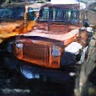

[[[ 34.328705  34.01126   27.19169 ]
  [ 27.375858  25.240685  23.81133 ]
  [ 37.419975  36.527153  26.833597]
  ...
  [207.74934  192.89392  177.65295 ]
  [193.03001  181.15857  168.56396 ]
  [165.94385  158.71486  148.49182 ]]

 [[ 37.51104   35.040314  26.429247]
  [ 22.868221  22.053925  18.419298]
  [ 24.410383  25.099363  15.943869]
  ...
  [224.33435  209.59508  202.14447 ]
  [219.92216  200.18564  204.6725  ]
  [202.54523  178.84502  157.73218 ]]

 [[ 38.308975  27.709549  22.393497]
  [ 39.900238  32.07734   26.14069 ]
  [ 53.77467   51.126015  43.759098]
  ...
  [163.7409   166.46724  145.77916 ]
  [149.22162  130.84412  115.589935]
  [144.68922  123.05548   96.49918 ]]

 ...

 [[ 35.898354  24.72152   18.935957]
  [ 32.45422   22.729849  22.565447]
  [ 44.940994  29.41214   23.339123]
  ...
  [ 30.939407  46.817715  52.54072 ]
  [ 33.27505   44.828247  47.25232 ]
  [ 44.133568  49.375233  49.05532 ]]

 [[ 33.86774   20.088717  19.543978]
  [ 31.91407   16.779678  18.203356]


In [45]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

path = "/content/drive/MyDrive/cars_train/04336.jpg"

X2 = cv2.imread(path)
X1 = cv2.resize(X2,(24,24), interpolation = cv2.INTER_AREA)
X = np.reshape(X1, (1,24,24,3))
X_batch = tf.cast(X, tf.float32)

generator, discriminator = model.layers
#generator.load_weights("DIV2K_gan.h5")
generator.load_weights("/content/DIV2K_generator_4X_epoch65000.h5")
Y = generator(X_batch/255)
cv2_imshow(X[0])
output = (Y[0].numpy() + 1)*127.5
cv2_imshow( output)

In [ ]:
import matplotlib.pyplot as plt
%inline
loss_disc = history_disc.history['loss']
loss_gen = history_gen.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)

plt.plot(epochs_range, loss_gen, label='Generator Loss')
plt.plot(epochs_range, loss_disc, label='Discriminator Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()